# 🔧 Remaining Useful Life (RUL) Prediction

Once a reliable wear–progression model is trained, we can extend it to estimate the **Remaining Useful Life (RUL)** of the cutter.  
The same polynomial regression model that predicts **incremental flute wear** per cut can be used to simulate the entire wear trajectory and infer how long the tool can continue operating before reaching a failure threshold.

---

## ⚙️ Procedure

1. **Predict incremental wear (Δwear)** for each cut in the test set using the trained polynomial model.
2. **Integrate** the predicted increments cumulatively to reconstruct the full wear curve.
3. Define a **failure threshold** — typically around 120 × 10⁻³ mm average wear.
4. For each cut:
   \[
   \text{RUL}_i = \max(0, i_{fail} - i)
   \]
   where \( i_{fail} \) is the first index where the predicted wear exceeds the threshold.
5. Plot both **true vs. predicted RUL** curves to visually evaluate how well the model anticipates end-of-life behavior.

---

## 🎯 Interpretation

- A good model will produce an RUL curve that **smoothly decreases** and intersects zero near the true failure point.  
- Overestimation → predicted tool lasts too long.  
- Underestimation → model predicts premature failure.  
- Unlike direct wear regression, this view highlights **how accurately the model captures the overall life trend** rather than just local wear increments.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
RAW_DIR = "c1"
PRE_DIR = "preprocess"

# collect all preprocessed feature files and their matching wear entries
features, labels = [], []

wear_df = pd.read_csv('c1_wear.csv')
wear_df.columns = wear_df.columns.str.lower()

files = sorted([f for f in os.listdir(PRE_DIR) if f.endswith(".csv")])

# compute incremental wear (difference between consecutive cuts)
wear_diff = wear_df[["flute_1", "flute_2", "flute_3"]].diff().fillna(0)

features, labels = [], []
for i, f in enumerate(files):
    feat = pd.read_csv(os.path.join(PRE_DIR, f))
    y = wear_diff.iloc[i].values
    features.append(feat.values.flatten())
    labels.append(y)

X = np.vstack(features)
Y = np.vstack(labels)


print("Features:", X.shape, "Labels:", Y.shape)

def evaluate_model(name, model, X_test, Y_test, preds):
    mae = mean_absolute_error(Y_test, preds)
    rmse = np.sqrt(mean_squared_error(Y_test, preds))
    r2 = r2_score(Y_test, preds)
    print(f"\n{name} Results:")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

    # plot true vs predicted for each flute
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for i, ax in enumerate(axes):
        ax.scatter(Y_test[:, i], preds[:, i], alpha=0.7)
        ax.plot([Y_test[:, i].min(), Y_test[:, i].max()],
                [Y_test[:, i].min(), Y_test[:, i].max()],
                'r--')
        ax.set_xlabel("True Wear")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Flute {i+1}")
    fig.suptitle(f"{name} — Predictions vs True")
    plt.show()

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=75, random_state=42, shuffle=False
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Features: (315, 10) Labels: (315, 3)
Train: (240, 10), Test: (75, 10)


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
poly_model.fit(X_train, Y_train)


,steps,"[('polynomialfeatures', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


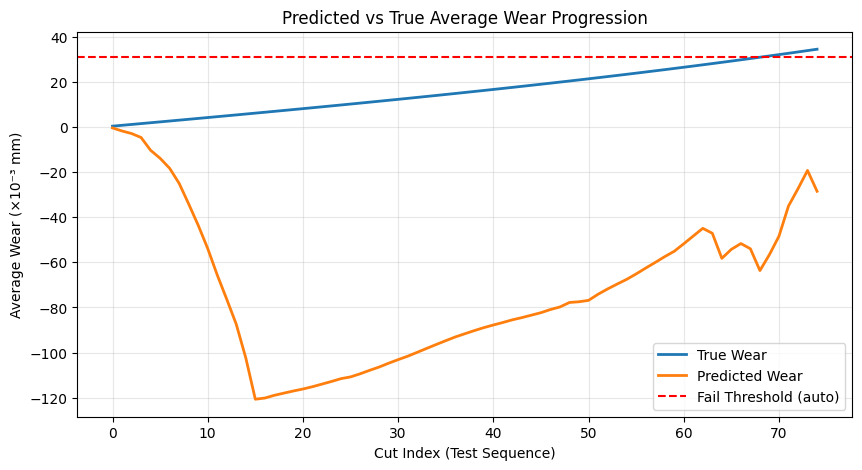

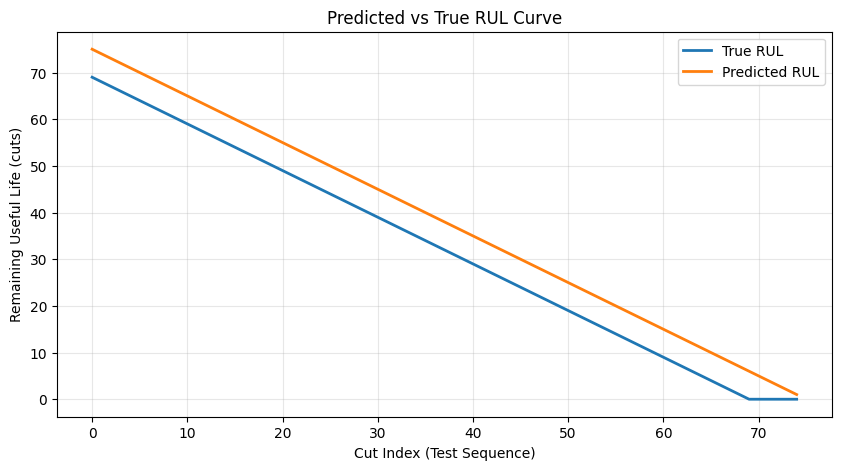

RUL Prediction MAE:  5.800
RUL Prediction RMSE: 5.859


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1️⃣ Predict incremental wear (Δwear) ===
Y_pred_dW = poly_model.predict(X_test)

# === 2️⃣ Integrate cumulative wear ===
Y_pred_wear = np.cumsum(Y_pred_dW, axis=0)
Y_true_wear = np.cumsum(Y_test, axis=0)

# === 3️⃣ Compute average wear across flutes ===
wear_true_avg = Y_true_wear.mean(axis=1)
wear_pred_avg = Y_pred_wear.mean(axis=1)

# === 4️⃣ Diagnostic plot: Predicted vs True Wear ===
plt.figure(figsize=(10,5))
plt.plot(wear_true_avg, label="True Wear", linewidth=2)
plt.plot(wear_pred_avg, label="Predicted Wear", linewidth=2)
plt.axhline(wear_true_avg.max()*0.9, color='r', linestyle='--', label='Fail Threshold (auto)')
plt.title("Predicted vs True Average Wear Progression")
plt.xlabel("Cut Index (Test Sequence)")
plt.ylabel("Average Wear (×10⁻³ mm)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 5️⃣ Choose threshold dynamically (90% of max true wear) ===
FAIL_THRESH = wear_true_avg.max() * 0.9

def compute_rul(wear, threshold):
    n = len(wear)
    rul = np.zeros(n)
    for i in range(n):
        # find first point >= threshold after index i
        future = np.where(wear[i:] >= threshold)[0]
        if len(future) > 0:
            rul[i] = future[0]
        else:
            rul[i] = n - i
    return rul

# === 6️⃣ Compute RUL for true and predicted curves ===
rul_true = compute_rul(wear_true_avg, FAIL_THRESH)
rul_pred = compute_rul(wear_pred_avg, FAIL_THRESH)

# === 7️⃣ Plot RUL curves ===
plt.figure(figsize=(10,5))
plt.plot(rul_true, label="True RUL", linewidth=2)
plt.plot(rul_pred, label="Predicted RUL", linewidth=2)
plt.xlabel("Cut Index (Test Sequence)")
plt.ylabel("Remaining Useful Life (cuts)")
plt.title("Predicted vs True RUL Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 8️⃣ Evaluate RUL metrics ===
mae = mean_absolute_error(rul_true, rul_pred)
rmse = np.sqrt(mean_squared_error(rul_true, rul_pred))
print(f"RUL Prediction MAE:  {mae:.3f}")
print(f"RUL Prediction RMSE: {rmse:.3f}")
